# Getting and preparation data

In [1]:
# Libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint

# Visuals
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier


### Obtener los datos

In [2]:
# Get data
train = pd.read_csv("supply_chain_train.csv", index_col="train_idx")
test = pd.read_csv("supply_chain_test.csv", index_col = "test_idx")
train.head()

CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
train_idx                                                                    
0          713071383            54      F                1         Unknown   
1          714246333            58      F                4     High School   
2          718206783            45      F                4         Unknown   
3          721096983            34      F                2        Graduate   
4          720028683            49      F                2     High School   

          Marital_Status Income_Category Card_Category  Months_on_book  \
train_idx                                                                
0                 Single         Unknown          Blue              36   
1                Married         Unknown          Blue              48   
2                 Single  Less than $40K          Gold              36   
3                 Single  Less than $40K          Blue              36   
4                Married     $40K - $60K          Blue              39   

           Total_Relationship_Count  ...  Contacts_Count_12_mon  Credit_Limit  \
train_idx                            ...                                        
0                                 1  ...                      3        3723.0   
1                                 1  ...                      3        5396.0   
2                                 6  ...                      3       15987.0   
3                                 4  ...                      4        3625.0   
4                                 5  ...                      4        2720.0   

           Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
train_idx                                                               
0                         1728           1995.0                 0.595   
1                         1803           3593.0                 0.493   
2                         1648          14339.0                 0.732   
3                         2517           1108.0                 1.158   
4                         1926            794.0                 0.602   

           Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
train_idx                                                         
0                     8554              99                0.678   
1                     2107              39                0.393   
2                     1436              36                1.250   
3                     2616              46                1.300   
4                     3806              61                0.794   

           Avg_Utilization_Ratio  Attrition_Flag  
train_idx                                         
0                          0.464               1  
1                          0.334               0  
2                          0.103               1  
3                          0.694               1  
4                          0.708               1  

[5 rows x 21 columns]

La columna CLIENTNUM, es únicamente un identificador. No será útil para los modelos así que se eliminará

In [3]:
train = train.drop('CLIENTNUM', axis=1)
test = test.drop('CLIENTNUM', axis=1)

### Analisis exploratorio

Primero se comprueban los valores nulos

In [4]:
train.isnull().sum()

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Attrition_Flag              0
dtype: int64

No hay valores nulos, pero sí se encuentran algunos 'Unknown'. Se comprueba el porcentaje de estos valores por cada columna.

In [5]:
print("Total Unknown per column:\n")
for col in train.columns:
    total_unknown = train.apply(lambda x: x[col] == 'Unknown', axis=1).sum()
    percent_unknown = round((total_unknown*100) / len(train), 2)
    if percent_unknown > 0:
        print(f"Column \033[38;5;196m{col}: {total_unknown} -> {percent_unknown} %\033[0;0m")
    else:
        print(f"Column {col}: {total_unknown} -> {percent_unknown} %")

Total Unknown per column:

Column Customer_Age: 0 -> 0.0 %
Column Gender: 0 -> 0.0 %
Column Dependent_count: 0 -> 0.0 %
Column Education_Level: 1205 -> 14.87 %
Column Marital_Status: 579 -> 7.15 %
Column Income_Category: 889 -> 10.97 %
Column Card_Category: 0 -> 0.0 %
Column Months_on_book: 0 -> 0.0 %
Column Total_Relationship_Count: 0 -> 0.0 %
Column Months_Inactive_12_mon: 0 -> 0.0 %
Column Contacts_Count_12_mon: 0 -> 0.0 %
Column Credit_Limit: 0 -> 0.0 %
Column Total_Revolving_Bal: 0 -> 0.0 %
Column Avg_Open_To_Buy: 0 -> 0.0 %
Column Total_Amt_Chng_Q4_Q1: 0 -> 0.0 %
Column Total_Trans_Amt: 0 -> 0.0 %
Column Total_Trans_Ct: 0 -> 0.0 %
Column Total_Ct_Chng_Q4_Q1: 0 -> 0.0 %
Column Avg_Utilization_Ratio: 0 -> 0.0 %
Column Attrition_Flag: 0 -> 0.0 %


Las columnas en rojo indican las que tienen estos valores y sus porcentajes:

- Education level tiene 14.87% como valores 'Unknown'
- Marital Status tiene 7.15%  
- Income_category tiene 10.97%  

Debido a que estas columnas tienen un alto número de estos varoes, por el momento, no se eliminarán porque podría perderse información importante.

¿Existen duplicados?

In [6]:
train.duplicated().sum()

0

Ahora se comprueba el tipo de variables

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8101 entries, 0 to 8100
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8101 non-null   int64  
 1   Gender                    8101 non-null   object 
 2   Dependent_count           8101 non-null   int64  
 3   Education_Level           8101 non-null   object 
 4   Marital_Status            8101 non-null   object 
 5   Income_Category           8101 non-null   object 
 6   Card_Category             8101 non-null   object 
 7   Months_on_book            8101 non-null   int64  
 8   Total_Relationship_Count  8101 non-null   int64  
 9   Months_Inactive_12_mon    8101 non-null   int64  
 10  Contacts_Count_12_mon     8101 non-null   int64  
 11  Credit_Limit              8101 non-null   float64
 12  Total_Revolving_Bal       8101 non-null   int64  
 13  Avg_Open_To_Buy           8101 non-null   float64
 14  Total_Am

Finalmente, se muestran los estadísticos básicos.

In [8]:
train.describe().T

count         mean          std     min       25%  \
Customer_Age              8101.0    46.306382     8.022527    26.0    41.000   
Dependent_count           8101.0     2.334773     1.289564     0.0     1.000   
Months_on_book            8101.0    35.923590     8.024359    13.0    31.000   
Total_Relationship_Count  8101.0     3.813233     1.551838     1.0     3.000   
Months_Inactive_12_mon    8101.0     2.346871     1.014177     0.0     2.000   
Contacts_Count_12_mon     8101.0     2.450315     1.100687     0.0     2.000   
Credit_Limit              8101.0  8636.548068  9086.419557  1438.3  2555.000   
Total_Revolving_Bal       8101.0  1160.382792   815.504293     0.0   326.000   
Avg_Open_To_Buy           8101.0  7476.165276  9080.279910     3.0  1341.000   
Total_Amt_Chng_Q4_Q1      8101.0     0.760809     0.216668     0.0     0.632   
Total_Trans_Amt           8101.0  4402.988150  3401.709545   510.0  2160.000   
Total_Trans_Ct            8101.0    64.907789    23.556379    10.0    45.000   
Total_Ct_Chng_Q4_Q1       8101.0     0.712176     0.239321     0.0     0.583   
Avg_Utilization_Ratio     8101.0     0.273187     0.274595     0.0     0.022   
Attrition_Flag            8101.0     0.839526     0.367068     0.0     1.000   

                               50%        75%        max  
Customer_Age                46.000     52.000     70.000  
Dependent_count              2.000      3.000      5.000  
Months_on_book              36.000     40.000     56.000  
Total_Relationship_Count     4.000      5.000      6.000  
Months_Inactive_12_mon       2.000      3.000      6.000  
Contacts_Count_12_mon        2.000      3.000      6.000  
Credit_Limit              4549.000  11128.000  34516.000  
Total_Revolving_Bal       1273.000   1782.000   2517.000  
Avg_Open_To_Buy           3495.000   9942.000  34516.000  
Total_Amt_Chng_Q4_Q1         0.738      0.859      2.675  
Total_Trans_Amt           3897.000   4739.000  18484.000  
Total_Trans_Ct              67.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714  
Avg_Utilization_Ratio        0.174      0.497      0.999  
Attrition_Flag               1.000      1.000      1.000

### Balanceo de los datos
Cuando se pretenden utilizar modelos machine learning, debe cromprobarse si los datos están o no balanceados

In [9]:
fig = go.Figure(go.Bar(x=train.Attrition_Flag.value_counts().index,
                      y=train.Attrition_Flag.value_counts(),
                      textposition = 'auto',
                      marker=dict(
                                color='rgb(158,202,225)',
                                line=dict(color='rgb(8,48,107)', width=1.5)),
                                opacity=0.6))
fig.update_layout(title="Balanced in target variable",
                 xaxis_title="target",
                  yaxis_title="Count")
fig.update_xaxes(tickvals=[0,1], ticktext=['0', '1'])
fig.show()

Como se puede ver, los datos están muy balanceados. Más adelante se deberá aplicar alguna tecnica para equlibrarlos.

### Outliers

Se comprueba la existencia de valores atípicos

In [10]:
fig  = make_subplots(rows=3, cols=5, shared_yaxes=True)
num_cols = train.select_dtypes(exclude=['object'])
for i, col in enumerate(num_cols):
    row = 1 if i<5 else 2 if i>4 and i<10 else 3
    column = (i % 5) + 1
    fig.add_trace(go.Box(y=num_cols[col], name=col), row=row, col=column)
fig.update_layout(height=600, width=1000, title_text="Boxplot by column", showlegend=False)
fig.show()

Existes diversas columnas con outliers, por lo que se seleccionarán para aplicarles más adelante un escalado más robusto.

In [11]:
def select_Outliers_Cols(data):
    '''
        This function make 2 lists of columns. First list keep the name of columns
        with outliers and the second ones keep column's name without outliers.
        
        Params: Dataframe with numeric columns
        
        Returns: 2 lists (outlierts_cols, no_outliers)
    '''
    outliers_cols = []
    for col in data:
        z_scores = stats.zscore(data[col])
        if np.any(np.abs(z_scores) > 3):
            outliers_cols.append(col)
    no_outliers = list(set(data).difference(set(outliers_cols)))
    try:
        no_outliers.remove('Attrition_Flag')
    except:
        pass
    return outliers_cols, no_outliers   

In [12]:
outliers_cols, no_outliers_cols = select_Outliers_Cols(num_cols)

Se separan la variable objetivo del resto de datos

In [13]:
X = train.drop('Attrition_Flag', axis=1)
y = train['Attrition_Flag']

Ahora se identifican las columnas numericas de las categoricas. A estas últimas se le aplicará get_dummies para categorizarlas.

In [14]:
categoric_variables = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=list(categoric_variables),
                   drop_first=True)

### Correlaciones
Se van a comprobar las posibles correlaciones en los datos

In [15]:
corr = X.corr()
fig = go.Figure(data=go.Heatmap(z=corr.values,
                                x=corr.index.values,
                                y=corr.columns.values,
                                colorscale= 'YlGnBu'))
fig.update_layout(height=1000, width=1000, title="Balanced in target variable")
fig.show()

# Escalado de los datos
Se guardan las variables para aplicar los distintos escalados, robusto o estándar. Para ello se crea una tubería (pipe) que aplique el escalado correspondiente a cada columna

In [16]:
def scaler_columns(X, outliers_cols, no_outliers_cols):
    pipe = ColumnTransformer(transformers=[('robust', RobustScaler(), outliers_cols),
                                            ('standard', StandardScaler(), no_outliers_cols)],
                            remainder='passthrough')
    X_scaled = pipe.fit_transform(X)
    return pd.DataFrame(X_scaled, columns = X.columns)

Se aplican los escalados

In [17]:
X = scaler_columns(X, outliers_cols, no_outliers_cols)

Se separan los datos en conjunto de entreno y test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Se crea un dataframe que contendrá la información de los distintos modelos, para comparar

In [19]:
final_models = pd.DataFrame(columns=['Model','f1_score(macro)','name', 'oversample', 'overfitting', 'features', 'params'])

# Entreno de modelos

### Selección de características
Para la selección de características importantes para cada modelo se utiliza la técnica de eliminación recursiva

In [20]:
def recursiveFeatureElimination(X, y, model, X_test):
    '''
        This function uses Recursive Feature Elimination method
        to select the most importance features. This is a features selection based
        in wrapped
        
        Params: model: The basic model to find the most important features
        
        Return: Selector object
    '''
    estimator = eval(model)
    rfecv = RFECV(estimator, step=1, cv=5, n_jobs = -1, scoring='f1_macro')
    rfecv = rfecv.fit(X,y)
    X_transformed = rfecv.transform(X)
    X_test_transform = rfecv.transform(X_test)    
    return X_transformed, X_test_transform, rfecv

In [21]:
def confusionMatrix(y_test, y_pred, model):
    '''
        This function show consufusion matrix
        
        Params: y_test, y_pred, model
    '''
    cm = confusion_matrix(y_test, y_pred)
    cm = ConfusionMatrixDisplay(cm).plot(cmap='YlGnBu')
    cm = cm.ax_.set_title(model+"Confusion Matrix")

In [22]:
def gridSearch(model, params, X_train, y_train, X_test, y_test, nameModel):
    '''
       This function do cross validation and check if exists overffiting
       and call to confusionMatrix function.
       
       Params : model, params to set, train and test data, name model
       
       Return: f1score value, 
               overfitting : string 'yes' or 'no'
               rnd.best_params_ : dict with best params of the model
    '''
    # Search for best parameters
    rnd = RandomizedSearchCV(model, 
                             params, 
                             n_iter = 30, 
                             cv=5, 
                             random_state = 42,
                             scoring = "f1_macro",
                             n_jobs = -1)
    
    rnd.fit(X_train, y_train)
    print("--------\nResults\n--------\n")
    print(f"Best hyperparameters found: {rnd.best_params_}")
    #print(rnd.cv_results_)
        
    # Cross Validation
    model.set_params(**rnd.best_params_)
    train_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    test_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1_macro')
    print("Cross validation train:", train_scores)
    print("Cross validation test", test_scores)
    
    # Overfitting
    if train_scores.mean() > test_scores.mean():
        overfitting = 'yes'
        print("There may be overfitting in the model")
    else:
        overfitting = 'no'
        print("The model generalizes well")
        
        
    # Training and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1Score = f1_score(y_test, y_pred, average='macro')
    print("\n-------\nMetrics\n-------")
    print(f"f1_score: {f1Score}")
    
    # Show confusion matrix
    confusionMatrix(y_test, y_pred, nameModel)
    
    return f1Score, overfitting, rnd.best_params_

La creación de los modelos seguirá la misma estructura:  

- Modelo básico y búsqueda de variables importantes  
- Diccionario con los parametros de configuración  
- Lamada a la función grid search  
- Mostrar resultados y matriz de confusión  
- Agregar resultados al dataframe

### AdaBoost 

In [23]:
adaBasicModel = "AdaBoostClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train, y_train, adaBasicModel, X_test)

--------
Results
--------

Best hyperparameters found: {'n_estimators': 80, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}
Cross validation train: [0.80518376 0.77154148 0.79015674 0.77721567 0.80609381]
Cross validation test [0.80524868 0.75711259 0.81612111 0.73719298 0.80423147]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.7970473822139629


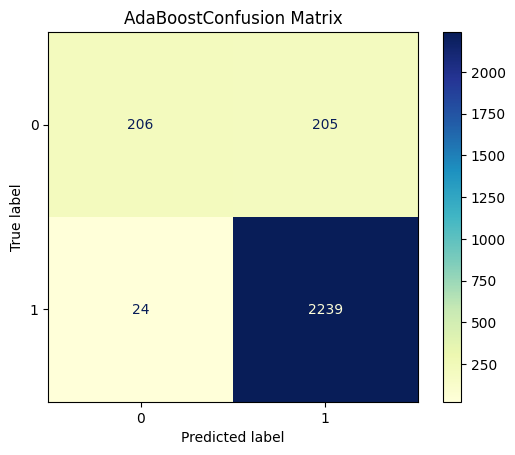

In [24]:
adaParams = {'n_estimators': range(50, 90, 1),
             'learning_rate': [0.1],
             'algorithm': ['SAMME','SAMME.R']}

f1Score, overfitting, bestParams = gridSearch(AdaBoostClassifier(), 
                     adaParams, 
                     X_train_transform, y_train, X_test_transform, y_test,
                     'AdaBoost')

In [25]:
new_row = pd.DataFrame({'Model':'AdaBoostClassifier()',
                       'f1_score(macro)':[f1Score],
                       'name':['ada_model'],
                       'oversample' : 'no',
                       'overfitting' : overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### Random Forest

In [26]:
rfBasicModel = "RandomForestClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train, y_train, rfBasicModel, X_test)

--------
Results
--------

Best hyperparameters found: {'n_jobs': -1, 'n_estimators': 925, 'min_samples_split': 4, 'max_leaf_nodes': 13, 'max_features': 'log2', 'max_depth': 11, 'criterion': 'log_loss', 'class_weight': 'balanced'}
Cross validation train: [0.8526785  0.87809379 0.83410249 0.84227613 0.86022334]
Cross validation test [0.87698016 0.86258348 0.8488914  0.86334112 0.8312816 ]
The model generalizes well

-------
Metrics
-------
f1_score: 0.8472711968856623


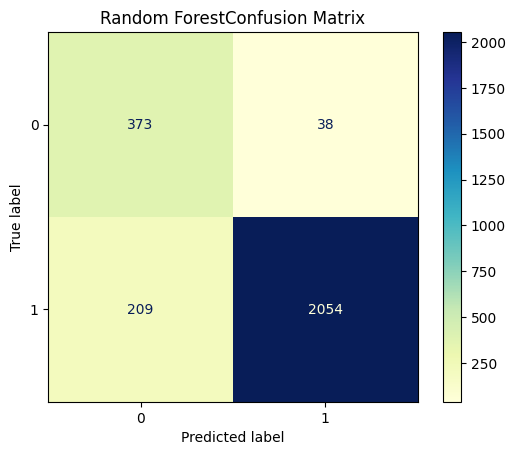

In [27]:
rForestparams = {'n_estimators': np.arange(100, 950, 25),
                 'criterion': ['gini','entropy','log_loss'],
                 'max_depth': np.arange(1, 15, 1),
                 'min_samples_split':[4, 5, 6], 
                 'class_weight':['balanced'],
                 'max_leaf_nodes':np.arange(4, 15, 1),
                 'max_features': ['sqrt','log2', None],
                 'n_jobs':[-1]}

f1Score, overfitting,  bestParams= gridSearch(RandomForestClassifier(), 
                                 rForestparams, 
                                 X_train_transform, y_train, X_test_transform, y_test,
                                 'Random Forest')

In [28]:
new_row = pd.DataFrame({'Model':'RandomForestClassifier()',
                       'f1_score(macro)':[f1Score],
                       'name':['randomForest_model'],
                        'oversample': 'no',
                        'overfitting' : overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### LGBM Classifier

In [29]:
lgbmBasicModel = "lgb.LGBMClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train, y_train, lgbmBasicModel, X_test)

--------
Results
--------

Best hyperparameters found: {'reg_alpha': 0, 'num_leaves': 19, 'n_estimators': 300, 'min_child_samples': 7, 'max_depth': 13, 'learning_rate': 0.1}
Cross validation train: [0.95445013 0.95164368 0.94599169 0.95893107 0.95712012]
Cross validation test [0.93587167 0.94459748 0.92162047 0.94802076 0.91268089]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.9439133276222942


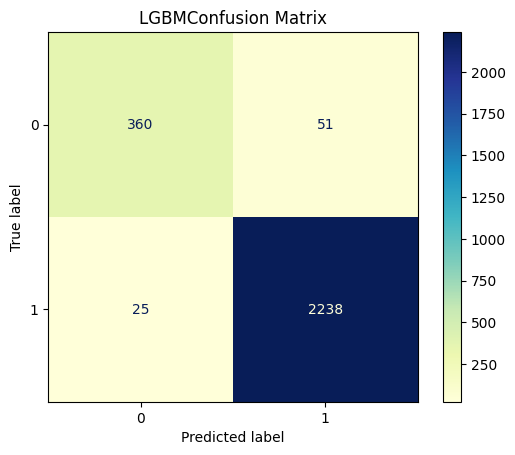

In [30]:
lgbmParams = {'num_leaves': np.arange(10, 20, 1),
              'max_depth': np.arange(-1, 21, 1),
              'learning_rate':[0.001, 0.01, 0.1, 1],
              'n_estimators': np.arange(100, 1025, 25),
              'reg_alpha': [0, 0.1],
              'min_child_samples': np.arange(5, 11, 1)}

f1Score, overfitting ,  bestParams= gridSearch(lgb.LGBMClassifier(), 
                        lgbmParams, 
                        X_train_transform, y_train, X_test_transform, y_test,
                       'LGBM')

In [31]:
new_row = pd.DataFrame({'Model':'lgb.LGBMClassifier()',
                       'f1_score(macro)':[f1Score],
                       'name':['lgbm_model'],
                        'oversample' : 'no',
                        'overfitting': overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### Gradient Boosting Classifier

In [32]:
gbBasicModel = "GradientBoostingClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train, y_train, gbBasicModel, X_test)

--------
Results
--------

Best hyperparameters found: {'n_estimators': 181, 'min_samples_split': 0.4, 'min_samples_leaf': 0.1, 'max_features': 'log2', 'max_depth': 5, 'loss': 'log_loss', 'learning_rate': 0.05}
Cross validation train: [0.88850684 0.90205628 0.89471417 0.87840784 0.88732569]
Cross validation test [0.8782024  0.87453831 0.8992029  0.83876701 0.86512347]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.8851158039640334


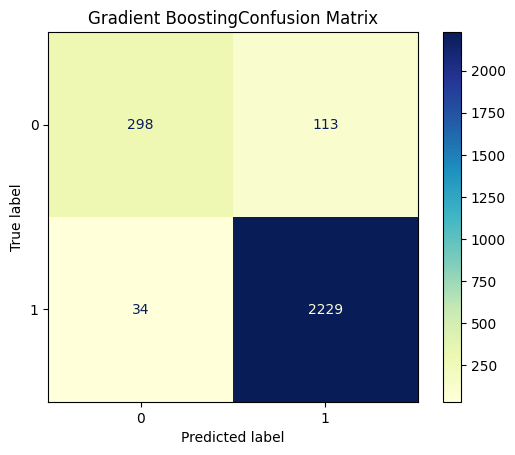

In [33]:
gradientBoostingParams = {'loss': ['log_loss','exponential'],
                          'max_depth': np.arange(1, 8, 1),
                          'learning_rate':np.arange(0.05, 0.3),
                          'n_estimators': np.arange(2, 200, 1),
                          'max_features': ['sqrt','log2'],
                          'min_samples_split': np.arange(0.1, 1, 0.1),
                          'min_samples_leaf':np.arange(0.1, 0.5, 0.1),
                          }

f1Score, overfitting,  bestParams = gridSearch(GradientBoostingClassifier(), 
                                 gradientBoostingParams, 
                                 X_train_transform, y_train, X_test_transform, y_test,
                                'Gradient Boosting')

In [34]:
new_row = pd.DataFrame({'Model':'GradientBoostingClassifier()',
                        'f1_score(macro)':[f1Score],
                       'name':['gb_model'],
                        'oversample' : 'no',
                        'overfitting' : overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})
final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### XGBoost

In [35]:
gbBasicModel = "XGBClassifier()"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train, y_train, gbBasicModel, X_test)

--------
Results
--------

Best hyperparameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 315, 'objective': 'binary:logistic', 'subsample': 0.6}
Cross validation train: [0.92781607 0.93693095 0.93752159 0.93722276 0.93469438]
Cross validation test [0.89444208 0.91564901 0.91623486 0.91132746 0.89141612]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.9285400745997088


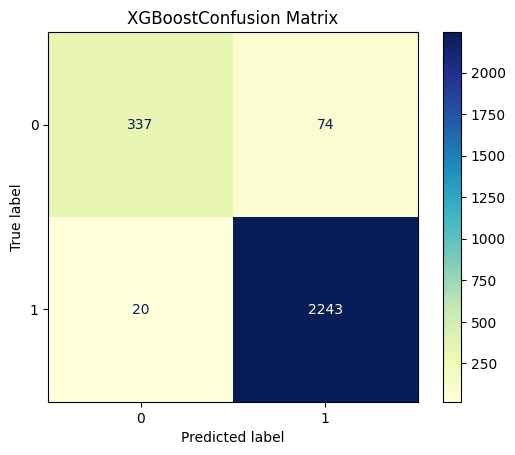

In [36]:
xgbParams = {'max_depth': np.arange(5, 11, 1),
             'learning_rate':[0.001, 0.01],
             'min_child_weight': randint(1, 5),
             'subsample': np.arange(0.5, 0.7, 0.1),
             'n_estimators': randint(100, 350, 25),
             'colsample_bytree': np.arange(0.5, 1.01, 0.1),
             'objective':['binary:logistic']}
f1Score, overfitting,  bestParams = gridSearch(XGBClassifier(), 
                     xgbParams, 
                     X_train_transform, y_train, X_test_transform, y_test,
                     'XGBoost')

In [37]:
new_row = pd.DataFrame({'Model':'XGBClassifier()',
                        'f1_score(macro)':[f1Score],
                       'name':['xboost'],
                        'oversample' : 'no',
                        'overfitting': overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})
final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

In [38]:
final_models

Model  f1_score(macro)                name  \
0          AdaBoostClassifier()         0.797047           ada_model   
1      RandomForestClassifier()         0.847271  randomForest_model   
2          lgb.LGBMClassifier()         0.943913          lgbm_model   
3  GradientBoostingClassifier()         0.885116            gb_model   
4               XGBClassifier()         0.928540              xboost   

  oversample overfitting                                           features  \
0         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
1         no          no  [Months_on_book, Total_Relationship_Count, Mon...   
2         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
3         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
4         no         yes  [Customer_Age, Dependent_count, Months_on_book...   

                                              params  
0  {'n_estimators': 80, 'learning_rate': 0.1, 'al...  
1  {'n_jobs': -1, 'n_estimators': 925, 'min_sampl...  
2  {'reg_alpha': 0, 'num_leaves': 19, 'n_estimato...  
3  {'n_estimators': 181, 'min_samples_split': 0.4...  
4  {'colsample_bytree': 0.6, 'learning_rate': 0.0...

La tabla anterior muestra los resultados obtenidos con los datos desbalanceados. Ahora se aplicará la técnica SMOTE para balancearlos y ver si mejoran los resultados.

# Transfomación de los datos

In [39]:
X = train.drop('Attrition_Flag', axis=1)
y = train['Attrition_Flag']
X = pd.get_dummies(X, columns=list(categoric_variables),
                   drop_first=True)

Se aplica Smote sobre los datos y se utiliza k-neighbors para seleccionar el número óptimo de vecinos para el cálculo.

In [40]:
# aplicar smote seleccionar k_neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

sm = SMOTE()
X_train_resample, y_train_resample = sm.fit_resample(X, y)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9]}
grid_search= GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resample, y_train_resample)
n_neighbors = grid_search.best_params_

In [41]:
oversample = SMOTE(k_neighbors = n_neighbors['n_neighbors'], random_state = 46)
X, y = oversample.fit_resample(X, y)

In [42]:
numericColumns = X.select_dtypes(exclude=['object'])
ColumnsWithOutliers, ColumnsWithoutOutliers = select_Outliers_Cols(numericColumns)
X = scaler_columns(X, ColumnsWithOutliers, ColumnsWithoutOutliers)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = 0.2, random_state = 42)

Igual que antes, se realizan los distintos modelos, ahora tras aplicar SMOTE

### Adaboost after SMOTE

--------
Results
--------

Best hyperparameters found: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 88}
Cross validation train: [0.89248484 0.91491029 0.90802289 0.90623859 0.90848051]
Cross validation test [0.90084232 0.9078778  0.93194643 0.90225612 0.91904762]
The model generalizes well

-------
Metrics
-------
f1_score: 0.9150485184298671


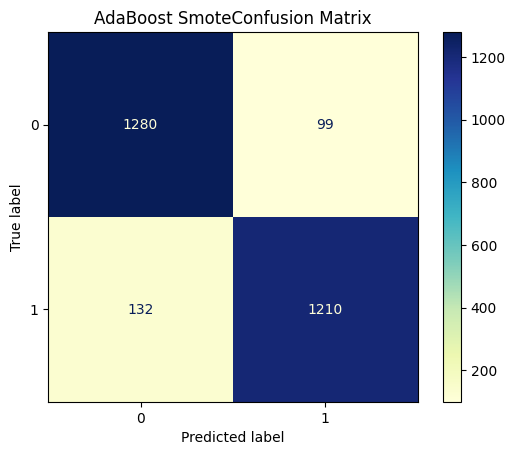

In [43]:
adaBasicModel = "AdaBoostClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train_s, y_train_s, adaBasicModel, X_test_s)

smoteAdaParams = {'n_estimators': randint(50, 90, 1),
             'learning_rate': [0.01, 0.1],
             'algorithm': ['SAMME','SAMME.R']}

f1Score, overfitting, bestParams= gridSearch(AdaBoostClassifier(), 
                      smoteAdaParams, 
                      X_train_transform, y_train_s, X_test_transform, y_test_s,
                     'AdaBoost Smote')

new_row = pd.DataFrame({'Model':'AdaBoostClassifier()',
                       'f1_score(macro)':[f1Score],
                       'name':['AdaBoost_Smote'],
                        'oversample': 'yes',
                        'overfitting': overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### Random Forest after SMOTE

--------
Results
--------

Best hyperparameters found: {'n_jobs': -1, 'n_estimators': 175, 'min_samples_split': 4, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 6, 'criterion': 'entropy', 'class_weight': 'balanced'}
Cross validation train: [0.91042349 0.92233454 0.91497514 0.91819604 0.9200367 ]
Cross validation test [0.9155824  0.93005251 0.95033929 0.93190222 0.92278994]
The model generalizes well

-------
Metrics
-------
f1_score: 0.9308795138265835


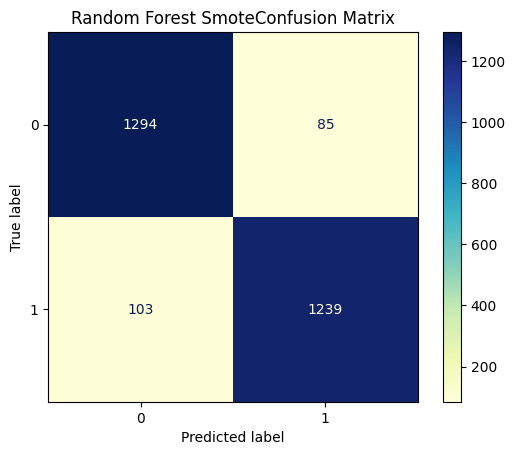

In [44]:
rfBasicModel = "RandomForestClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train_s, y_train_s, rfBasicModel, X_test_s)

smoteRForestparams = {'n_estimators': np.arange(100, 950, 25),
                 'criterion': ['gini','entropy','log_loss'],
                 'max_depth': np.arange(1, 15, 1),
                 'min_samples_split':[4, 5, 6], 
                 'class_weight':['balanced'],
                 'max_leaf_nodes':np.arange(4, 15, 1),
                 'max_features': ['sqrt','log2', None],
                 'n_jobs':[-1]}

f1Score, overfitting, bestParams = gridSearch(RandomForestClassifier(), 
                                 smoteRForestparams, 
                                 X_train_transform, y_train_s, X_test_transform, y_test_s,
                                 'Random Forest Smote')

new_row = pd.DataFrame({'Model':'RandomForestClassifier()',
                       'f1_score(macro)':[f1Score],
                       'name':['randomForest_Smote'],
                        'oversample': 'yes',
                        'overfitting': overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### LGBM after SMOTE

--------
Results
--------

Best hyperparameters found: {'reg_alpha': 0, 'num_leaves': 98, 'n_estimators': 550, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.15000000000000002}
Cross validation train: [0.98851622 0.98713234 0.98575353 0.9820772  0.98713234]
Cross validation test [0.97614165 0.97239952 0.9816087  0.97426157 0.97793372]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.9867656214197086


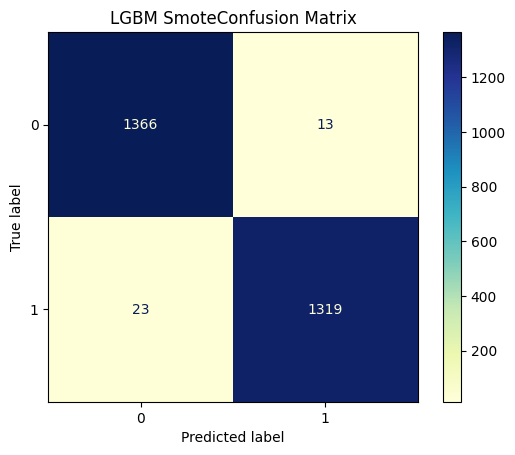

In [45]:
lgbmBasicModel = "lgb.LGBMClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train_s, y_train_s, lgbmBasicModel, X_test_s)

SmotelgbmParams = {'num_leaves': np.arange(10, 101, 1),
              'max_depth': np.arange(1, 10, 1),
              'learning_rate':np.arange(0.05, 0.2, 0.05),
              'n_estimators': np.arange(100, 800, 25),
              'reg_alpha': [0, 0.1],
              'min_child_samples': np.arange(5, 11, 1)}

f1Score, overfitting,  bestParams = gridSearch(lgb.LGBMClassifier(), 
                        SmotelgbmParams, 
                        X_train_transform, y_train_s, X_test_transform, y_test_s,
                       'LGBM Smote')

new_row = pd.DataFrame({'Model':'lgb.LGBMClassifier()',
                       'f1_score(macro)':[f1Score],
                       'name':['lgbm_model_Smote'],
                        'oversample' : 'yes',
                        'overfitting' : overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### Gradient Boosting after SMOTE

--------
Results
--------

Best hyperparameters found: {'n_estimators': 80, 'min_samples_split': 9, 'min_samples_leaf': 70, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'exponential', 'learning_rate': 0.2}
Cross validation train: [0.9797887  0.98207717 0.98207657 0.97610286 0.98023897]
Cross validation test [0.97063419 0.97057829 0.97425914 0.9760964  0.96689566]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.9823565074833005


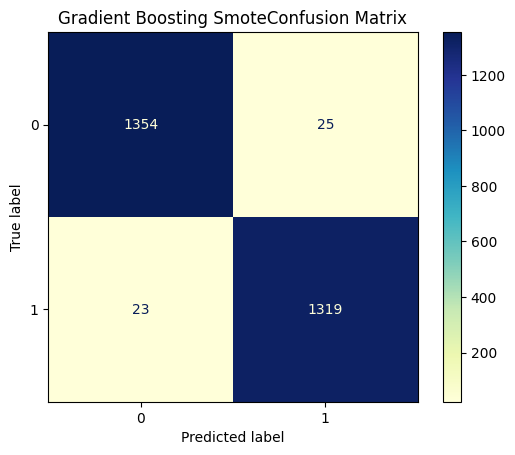

In [46]:
gbBasicModel = "GradientBoostingClassifier(random_state = 42)"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train_s, y_train_s, gbBasicModel, X_test_s)

smoteGradientBoostingParams = {'loss': ['log_loss','exponential'],
                          'max_depth': np.arange(2, 9, 1),
                          'learning_rate':np.arange(0.05, 0.2, 0.05),
                          'n_estimators': np.arange(10, 81, 5),
                          'max_features': ['sqrt','log2'],
                          'min_samples_split': np.arange(2, 10, 1),
                          'min_samples_leaf':np.arange(30, 71, 5)}

f1Score, overfitting,  bestParams = gridSearch(GradientBoostingClassifier(), 
                                 smoteGradientBoostingParams, 
                                 X_train_transform, y_train_s, X_test_transform, y_test_s,
                                'Gradient Boosting Smote')

new_row = pd.DataFrame({'Model':'GradientBoostingClassifier()',
                        'f1_score(macro)':[f1Score],
                       'name':['gb_model_Smote'],
                        'oversample' : 'yes',
                        'overfitting': overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

### XGBoost after SMOTE

--------
Results
--------

Best hyperparameters found: {'subsample': 0.7, 'objective': 'binary:logistic', 'n_estimators': 890, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.08000000000000002, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7}
Cross validation train: [0.9853008  0.98483453 0.98483402 0.9820772  0.98483453]
Cross validation test [0.9742973  0.96688984 0.97241892 0.97058466 0.9760964 ]
There may be overfitting in the model

-------
Metrics
-------
f1_score: 0.9823541618929448


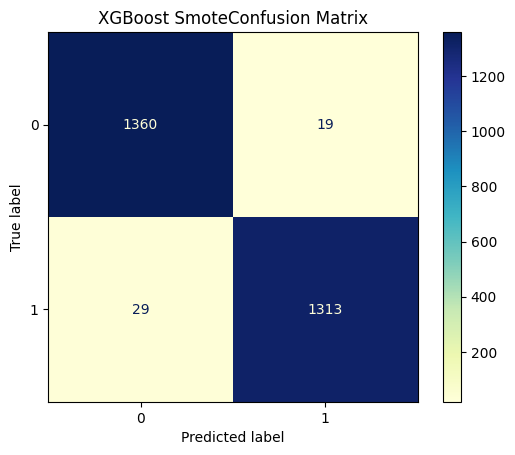

In [47]:
gbBasicModel = "XGBClassifier()"
X_train_transform, X_test_transform, rfecv = recursiveFeatureElimination(X_train_s, y_train_s, gbBasicModel, X_test_s)

smoteXgbParams = {'max_depth': np.arange(1, 6, 1),
             'learning_rate': np.arange(0.05, 0.09, 0.01),
             'min_child_weight': np.arange(1, 5, 1),
             'subsample': np.arange(0.6, 0.8, 0.1),
             'n_estimators': np.arange(100, 1000, 10),
             'colsample_bytree': np.arange(0.6, 0.8, 0.1),
             'colsample_bylevel': np.arange(0.6, 0.8, 0.1),
             'objective':['binary:logistic']}

f1Score, overfitting,  bestParams = gridSearch(XGBClassifier(), 
                     smoteXgbParams,
                     X_train_transform, y_train_s, X_test_transform, y_test_s,
                     'XGBoost Smote')

new_row = pd.DataFrame({'Model':'XGBClassifier()',
                        'f1_score(macro)':[f1Score],
                       'name':['xboost_Smote'],
                        'oversample' : 'yes',
                        'overfitting': overfitting,
                       'features':[list(rfecv.get_feature_names_out())],
                       'params': [bestParams]})

final_models = pd.concat([final_models, new_row], 
                         ignore_index=True, 
                         axis=0)

In [48]:
final_models

Model  f1_score(macro)                name  \
0          AdaBoostClassifier()         0.797047           ada_model   
1      RandomForestClassifier()         0.847271  randomForest_model   
2          lgb.LGBMClassifier()         0.943913          lgbm_model   
3  GradientBoostingClassifier()         0.885116            gb_model   
4               XGBClassifier()         0.928540              xboost   
5          AdaBoostClassifier()         0.915049      AdaBoost_Smote   
6      RandomForestClassifier()         0.930880  randomForest_Smote   
7          lgb.LGBMClassifier()         0.986766    lgbm_model_Smote   
8  GradientBoostingClassifier()         0.982357      gb_model_Smote   
9               XGBClassifier()         0.982354        xboost_Smote   

  oversample overfitting                                           features  \
0         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
1         no          no  [Months_on_book, Total_Relationship_Count, Mon...   
2         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
3         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
4         no         yes  [Customer_Age, Dependent_count, Months_on_book...   
5        yes          no  [Customer_Age, Months_on_book, Total_Relations...   
6        yes          no  [Customer_Age, Dependent_count, Months_on_book...   
7        yes         yes  [Customer_Age, Dependent_count, Months_on_book...   
8        yes         yes  [Customer_Age, Months_on_book, Total_Relations...   
9        yes         yes  [Customer_Age, Months_on_book, Total_Relations...   

                                              params  
0  {'n_estimators': 80, 'learning_rate': 0.1, 'al...  
1  {'n_jobs': -1, 'n_estimators': 925, 'min_sampl...  
2  {'reg_alpha': 0, 'num_leaves': 19, 'n_estimato...  
3  {'n_estimators': 181, 'min_samples_split': 0.4...  
4  {'colsample_bytree': 0.6, 'learning_rate': 0.0...  
5  {'algorithm': 'SAMME.R', 'learning_rate': 0.1,...  
6  {'n_jobs': -1, 'n_estimators': 175, 'min_sampl...  
7  {'reg_alpha': 0, 'num_leaves': 98, 'n_estimato...  
8  {'n_estimators': 80, 'min_samples_split': 9, '...  
9  {'subsample': 0.7, 'objective': 'binary:logist...

Esta es la tabla resultante con todos los modelos

# Models Comparation

En este punto, únicamente se seleccionan los modelos que no han sufrido overfitting y se ordenan según el score f1macro

In [49]:
final_models = final_models[final_models['overfitting']=='no'].sort_values(by=['f1_score(macro)'], ascending=False).reset_index()

In [50]:
final_models

index                     Model  f1_score(macro)                name  \
0      6  RandomForestClassifier()         0.930880  randomForest_Smote   
1      5      AdaBoostClassifier()         0.915049      AdaBoost_Smote   
2      1  RandomForestClassifier()         0.847271  randomForest_model   

  oversample overfitting                                           features  \
0        yes          no  [Customer_Age, Dependent_count, Months_on_book...   
1        yes          no  [Customer_Age, Months_on_book, Total_Relations...   
2         no          no  [Months_on_book, Total_Relationship_Count, Mon...   

                                              params  
0  {'n_jobs': -1, 'n_estimators': 175, 'min_sampl...  
1  {'algorithm': 'SAMME.R', 'learning_rate': 0.1,...  
2  {'n_jobs': -1, 'n_estimators': 925, 'min_sampl...

# Modelo final

Se cargan los datos

In [51]:
test = pd.read_csv("supply_chain_test.csv", index_col = "test_idx")

Se realizan diversas transformaciones a los datos de test, necesarias para adaptar el dataset a los datos de predicción:  

- Se aplica get_dummies  
- Se escalan los datos por columnas en funcion de si tienen outliers  
- Se filtran las columnas


In [52]:
# Dummies y escalados
test = pd.get_dummies(test, columns=list(categoric_variables),
                   drop_first=True)
test = test.loc[:, final_models.features[0]]
new_outliers = [i for i in test.columns if i in outliers_cols]
new_no_outliers = [i for i in test.columns if i in no_outliers_cols]
test_transform  = scaler_columns(test, new_outliers, new_no_outliers)

# Seleccion de coluimnas
X_train_s = X_train_s.loc[:, final_models['features'][0]]
X_test_s = X_test_s.loc[:, final_models['features'][0]]

# Creacion del modelo
model = eval(final_models['Model'][0])
params = final_models['params'][0]
model = model.set_params(**params)

if final_models['oversample'][0] == 'yes':
    model.fit(X_train_s, y_train_s)
else:
    model.fit(X_train, y_train)

# Predicciones
predictions = model.predict(test_transform)

Las predicciones son guardadas en un json

In [53]:
df_pred = pd.DataFrame(predictions, columns=['target'])
df_pred.to_json("predictions.json")